# Import the necessary ML Libraries

In [1]:
# Libraries for managing dataset
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# The defaultdict of collections library
from collections import defaultdict as dd

In [3]:
# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Libraries of the ML models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import LinearSVC as LSVM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import CategoricalNB as NBC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression as LR

from sklearn.metrics import recall_score, make_scorer

In [5]:
# Libraries for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Load the final_combined_extracted_octapeptide_features into Pandas DF and Split the Dataset into Training, Validation, and Testing Sets and Assign X and y Variables

In [6]:
df = pd.read_csv("../datasets/final_combined_extracted_features_dataset/final_combined_extracted_octapeptide_features.csv", 
                 index_col=0)

training_set, validation_set, testing_set = np.split(df.sample(frac=1, random_state=123), [int(.7*len(df)), int(.8*len(df))])

X_training = training_set.drop(["cleavage Status"], axis=1)
y_training = training_set["cleavage Status"].copy().map({"cleaved": 1, "uncleaved": 0})

X_validation = validation_set.drop(["cleavage Status"], axis=1)
y_validation = validation_set["cleavage Status"].copy().map({"cleaved": 1, "uncleaved": 0})

X_testing = testing_set.drop(["cleavage Status"], axis=1)
y_testing = testing_set["cleavage Status"].copy().map({"cleaved": 1, "uncleaved": 0})

# 10-Fold Cross Validation Experiment using the Training Dataset

In [7]:
## Instantiating the classifier classes and storing in a list
clf_list_for_CV = [(LSVM(random_state=0, tol=1e-5, C=5), "LinearSVC"),
    (LDA(solver="svd", tol=1e-8), "LinearDiscriminantAnalysis"),
    (GBC(n_estimators=800, learning_rate=1.0, max_depth=1, random_state=0, 
         tol=1e-10, ccp_alpha=0.0), "GradientBoostingClassifier"),
    (KNN(n_neighbors=4, n_jobs=-1, metric="minkowski", leaf_size=30, p=2, 
         weights="distance"), "KNeighorsClassifier"),
    (NBC(alpha=1), "CategoricalNB"),
    (DTC(criterion="gini", splitter="best", max_depth=None, ccp_alpha=0.0), "DecisionTreeClassifier"),
    (MLPC(hidden_layer_sizes=100, activation ="relu", solver="adam", alpha=0.0001, 
          learning_rate="adaptive", max_iter=200, tol=1e-4, momentum=0.9, epsilon=1e-8,), "MLPClassifier"),
    (Perceptron(penalty="l2", alpha=0.0000001, max_iter=4000, tol=1e-7, eta0=2, n_jobs=-1), "Perceptron"),       
    (LR(random_state=0, penalty="l2", tol=1e-3, C=0.99, solver="lbfgs", max_iter=150,
       n_jobs=-1), "LogisticRegression")]

# Since specificity_score is not specified directly in sklearn, we create it using the make_scorer function
specificity = make_scorer(recall_score, pos_label=0) # although, this is direcly available in sklearn, but we still chose to 
sensitivity = make_scorer(recall_score, pos_label=1) # create it with the make_scorer function to avoid confusion
                                                     
scores = dd(list)

for clf, name in clf_list_for_CV:
    scores["Classifier"].append(name)
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    score = cross_val_score(clf, X_training.values, y_training.values, scoring="balanced_accuracy", cv=cv, n_jobs=-1)
    scores["Balanced Accuracy"].append(score)
    score = cross_val_score(clf, X_training.values, y_training.values, scoring=sensitivity, cv=cv, n_jobs=-1)
    scores["Sensitivity"].append(score)
    score = cross_val_score(clf, X_training.values, y_training.values, scoring=specificity, cv=cv, n_jobs=-1)
    scores["Specificity"].append(score)
    score = cross_val_score(clf, X_training.values, y_training.values, scoring="f1_macro", cv=cv, n_jobs=-1)
    scores["F1 Index"].append(score)
    score = cross_val_score(clf, X_training.values, y_training.values, scoring="roc_auc", cv=cv, n_jobs=-1)
    scores["AUC"].append(score)
    score = cross_val_score(clf, X_training.values, y_training.values, scoring="jaccard_macro", cv=cv, n_jobs=-1)
    scores["JI"].append(score)

In [8]:
scores

defaultdict(list,
            {'Classifier': ['LinearSVC',
              'LinearDiscriminantAnalysis',
              'GradientBoostingClassifier',
              'KNeighorsClassifier',
              'CategoricalNB',
              'DecisionTreeClassifier',
              'MLPClassifier',
              'Perceptron',
              'LogisticRegression'],
             'Balanced Accuracy': [array([0.83879849, 0.89698389, 0.87011012, 0.73464455, 0.81654721,
                     0.79394116, 0.79029502, 0.625     , 0.88402572, 0.66666667]),
              array([0.88650559, 0.85178337, 0.89049145, 0.80956746, 0.788024  ,
                     0.84365364, 0.87105175, 0.86568579, 0.87162051, 0.79374794]),
              array([0.6097551 , 0.84335963, 0.88354701, 0.87773981, 0.80062922,
                     0.58829902, 0.84661222, 0.85773162, 0.86117293, 0.83790801]),
              array([0.67044707, 0.74876726, 0.69173241, 0.68689057, 0.65653388,
                     0.71393449, 0.67393116, 0.71985246

# Create Various DFs to Store Each of the Metrics Contained in the Scores Dictionary

In [9]:
clf_names=["LSVC", "LDA","GBC","KNN", "NBC", "DTC", "MLPC", "PC", "LR"]

BA = pd.DataFrame(scores['Balanced Accuracy'], index=clf_names).T
BA.fillna(BA['NBC'].mean(), inplace=True)
df_BA = BA.round(2)

Sen = pd.DataFrame(scores['Sensitivity'], index=clf_names).T
Sen.fillna(Sen['NBC'].mean(), inplace=True)
df_Sen = Sen.round(2)

Spec = pd.DataFrame(scores['Specificity'], index=clf_names).T
Spec.fillna(Spec['NBC'].mean(), inplace=True)
df_Spec = Spec.round(2)

FI = pd.DataFrame(scores['F1 Index'], index=clf_names).T
FI.fillna(FI['NBC'].mean(), inplace=True)
df_FI = FI.round(2)

AUC = pd.DataFrame(scores['AUC'], index=clf_names).T
AUC.fillna(AUC['NBC'].mean(), inplace=True)
df_AUC = AUC.round(2)

JI = pd.DataFrame(scores['JI'], index=clf_names).T
JI.fillna(JI['NBC'].mean(), inplace=True)
df_JI = JI.round(2)

In [10]:
df_BA.to_csv("../results/10-Fold_CV_Result_For_Balanced_Accuracy.csv")
df_Sen.to_csv("../results/10-Fold_CV_Result_For_Sensitivity.csv")
df_Spec.to_csv("../results/10-Fold_CV_Result_For_Specificity.csv")
df_FI.to_csv("../results/10-Fold_CV_Result_For_F1-Index.csv")
df_AUC.to_csv("../results/10-Fold_CV_Result_For_AUC.csv")
df_JI.to_csv("../results/10-Fold_CV_Result_For_Jaccard_Index.csv")

# Plot the Distribution of the Scores of Performance Metrics Across the Models 

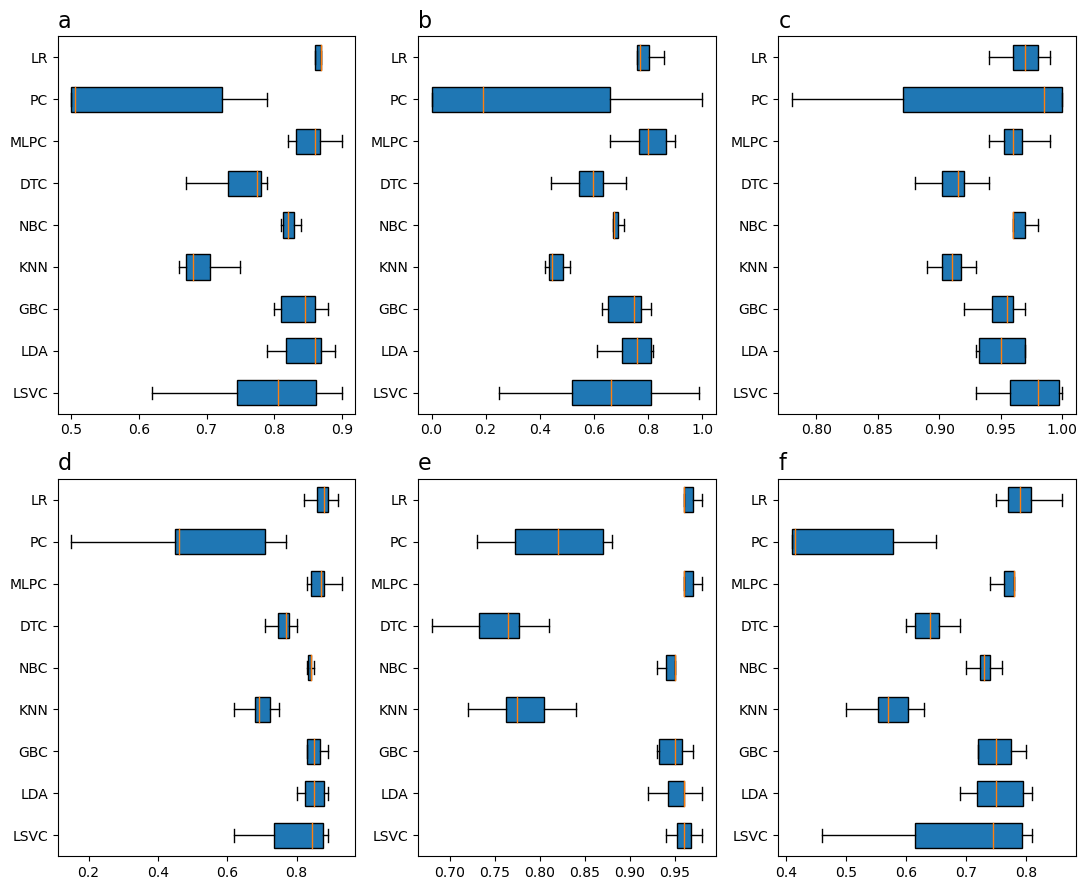

In [17]:
titles = ["a", "b", "c", "d", "e", "f"]

metrics = [df_BA, df_Sen, df_Spec, df_FI, df_AUC, df_JI]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 9))

for metric, ax, title in zip(metrics, axes.flatten(), titles):
    ax.boxplot(metric, vert=False, labels=clf_names, widths=0.6, patch_artist=True, showfliers=False)
    ax.set_title(label=title, loc="left", fontsize=16)
    ax.grid(False)
    ax.set(xlabel=None)
    ax.set(ylabel=None)
      
plt.tight_layout() 
plt.savefig('../results/Distribution_of_the_Performance_Metrics_Across_the_Models.png', dpi=1200)
plt.show()

In [12]:
from scipy.stats import mannwhitneyu as mwt
from scipy.stats import alexandergovern as agt

In [13]:
p_values = dd(list)

for model in ["LSVC", "LDA", "GBC", "KNN", "NBC", "DTC", "MLPC", "PC", "LR"]:
    _, p = mwt(df_BA[model], df_BA["LSVC"])
    p_values[model].append(p)  

In [14]:
p_values

defaultdict(list,
            {'LSVC': [1.0],
             'LDA': [0.20848999683273262],
             'GBC': [0.6764349997242503],
             'KNN': [0.012214156383963727],
             'NBC': [0.7900217196826306],
             'DTC': [0.10984000750736599],
             'MLPC': [0.16054994537681433],
             'PC': [0.0037326491097394174],
             'LR': [0.07945317354167836]})

In [15]:
p_values_df = pd.DataFrame(p_values, index=["p-value"]).T.astype(float).round(4)
p_values_df.to_csv("../results/p_values.csv")
p_values_df

,p-value
LSVC,1.0000
LDA,0.2085
GBC,0.6764
KNN,0.0122
NBC,0.7900
DTC,0.1098
MLPC,0.1605
PC,0.0037
LR,0.0795


In [16]:
df_Sen

,LSVC,LDA,GBC,KNN,NBC,DTC,MLPC,PC,LR
0,0.68,0.81,0.26,0.44,0.67,0.64,0.81,1.00,0.82
1,0.85,0.74,0.72,0.58,0.69,0.72,0.76,0.67,0.78
2,0.76,0.82,0.81,0.47,0.71,0.56,0.90,0.00,0.86
3,0.49,0.69,0.80,0.45,0.72,0.51,0.79,0.37,0.76
4,0.65,0.61,0.63,0.42,0.58,0.62,0.66,0.63,0.62
5,0.61,0.75,0.25,0.49,0.67,0.59,0.82,0.00,0.76
6,0.99,0.77,0.75,0.44,0.63,0.54,0.79,0.00,0.76
7,0.25,0.81,0.78,0.51,0.68,0.60,0.89,0.01,0.81
8,0.83,0.81,0.76,0.43,0.69,0.65,0.88,0.00,0.78
9,0.33,0.65,0.75,0.35,0.67,0.44,0.76,0.81,0.68
